please download dataset
[here](http://archive.ics.uci.edu/ml/datasets/online+retail)

and in case you need a little help, I'm writing a list that can serve you as a guideline.
- rfm_case.py: a case study for implementing K-means algorithm, including trying to cluster based on RFM Analysis (quantile)
- rfm_plot.py: filled with a set of commandlines to visualize the result
- rfm_score.csv: the result of RFM-analysis ; the data contains CustomerID,Recency,Frequency,Monetary,r_seg,f_seg,m_seg,RFMScore 
- rfmkmean.csv: the result of K-means and join with rfm_score.csv; CustomerID,r_sca,f_sca,m_sca,prediction,RFMScore
- rfm_kmeans_pred.csv: the final result where we put all data that we may need together; CustomerID,r_sca,f_sca,m_sca,prediction,RFMScore,rfm_class


RFM analysis is a customer segmentation technique that uses past purchase history to divide customers into groups. Here is a table of segments we use for this case

![rfm](rfm.png)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("RFM Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
df = spark.read.format('com.databricks.spark.csv').\
    options(header='true', \
    inferschema='true').\
    load("/Users/Devi/Documents/Purwadhika/awal/onlineretail.csv")
df.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 5 rows



In [7]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [8]:
print('\n Shape =', (df.count(), len(df.columns)))


 Shape = (541909, 8)


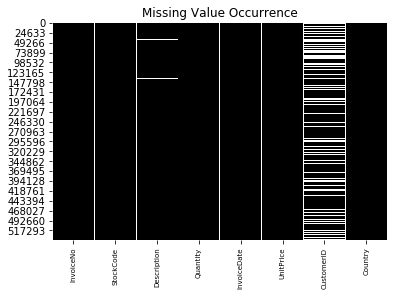

In [9]:
%matplotlib inline
from pyspark.sql import functions as F
## Check for missing value
ax=plt.subplot(111)
sns.heatmap(df.select([F.isnull(c) for c in df.columns]).collect(),cbar=False,cmap='Greys_r')
ax.set_xticklabels(df.columns, rotation='vertical',fontsize=7)
plt.title('Missing Value Occurrence')
plt.show()

In [10]:
## Delete rows with null value
from pyspark.sql.functions import count
def data_count(inp):
    inp.agg(*[count(i).alias(i) for i in inp.columns]).show()  
data_count(df) # raw data
df_new = df.dropna(how='any') 
data_count(df_new) # after we drop rows with null values

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   541909|   541909|     540455|  541909|     541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+-----------+---------+----------+-------+

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   406829|   406829|     406829|  406829|     406829|   406829|    406829| 406829|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [11]:
## Change datetime format
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col 
time_format = "MM/dd/yy HH:mm"
df_new = df_new.withColumn('NewInvoiceDate', to_utc_timestamp(unix_timestamp(col('InvoiceDate'),time_format).cast('timestamp'),'UTC'))  
df_new.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
+---------+---------+-----------

In [12]:
## Calculate total price and create the column
from pyspark.sql.functions import round
df_new = df_new.withColumn('TotalPrice', round( df.Quantity * df.UnitPrice, 2 ))

In [13]:
## Calculate time diff
from pyspark.sql.functions import mean, min, max, sum
date_max = df_new.select(max('NewInvoiceDate')).toPandas()

In [14]:
## Calculate duration
df_new = df_new.withColumn('Duration', datediff(lit(date_max.iloc[0][0]), 'NewInvoiceDate')) 
df_new.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+----------+--------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|TotalPrice|Duration|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+----------+--------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|      15.3|     373|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|     373|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|      22.0|     373|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|     373|
|   536365|  

In [15]:
## Calculate rfm
recency = df_new.groupBy('CustomerID').agg(min('Duration').alias('Recency'))
frequency = df_new.groupBy('CustomerID', 'InvoiceNo').count().groupBy('CustomerID').agg(count("*").alias("Frequency"))
monetary = df_new.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))
rfm = recency.join(frequency,'CustomerID', how = 'inner').join(monetary,'CustomerID', how = 'inner')
rfm.show(5)
rfm.describe().show()
# # rfm.toPandas().to_csv('rfm_value.csv',index=False)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     10|        1|   336.4|
|     17389|      0|       43|31300.08|
|     12940|     46|        4|  876.29|
|     13623|     30|        7|  672.44|
|     14450|    180|        3|  483.25|
+----------+-------+---------+--------+
only showing top 5 rows

+-------+------------------+------------------+-----------------+------------------+
|summary|        CustomerID|           Recency|        Frequency|          Monetary|
+-------+------------------+------------------+-----------------+------------------+
|  count|              4372|              4372|             4372|              4372|
|   mean|15299.677721866423| 91.58119853613907| 5.07548032936871|1898.4597003659658|
| stddev|1722.3907054276908|100.77213931384833|9.338754163574729| 8219.345141139722|
|    min|             12346|                 0|                1|          -4287.63|
|    max|           

In [16]:
## Cutting point
def describe_quintile(df_in, columns):
    quintiles = [25, 50, 75]
    quars = np.transpose([np.percentile(df_in.select(x).collect(),quintiles) for x in columns])
    quars = pd.DataFrame(quars, columns=columns)
    quars['quintile'] = [str(p) + '%' for p in quintiles]
    new_df = quars
    new_df = new_df.set_index('quintile')
    new_df = new_df.round(2)
    return new_df
cols = ['Recency','Frequency','Monetary']
df_quar = describe_quintile(rfm,cols)
print(df_quar)

          Recency  Frequency  Monetary
quintile                              
25%          16.0        1.0    293.36
50%          50.0        3.0    648.08
75%         143.0        5.0   1611.72


In [17]:
def RScore(x):
    rs=0
    for i in range(3):
        if x <= df_quar.iloc[i,0]:
            rs=i+1
            break
        elif x > df_quar.iloc[2,0]:
            rs=4
            break
    return rs

In [18]:
def FScore(x):
    fs=4
    for i in range(3):
        if x <= df_quar.iloc[i,1]:
            fs-=i
            break
        elif x > df_quar.iloc[2,1]:
            fs=1
            break
    return fs

In [19]:
def MScore(x):
    ms=4
    for i in range(3):
        if x <= df_quar.iloc[i,2]:
            ms-=i
            break
        elif x > df_quar.iloc[2,2]:
            ms=1
            break
    return ms

In [20]:
from pyspark.sql.functions import udf 
from pyspark.sql.types import IntegerType
R_udf = udf(lambda x: RScore(x), IntegerType())
F_udf = udf(lambda x: FScore(x), IntegerType())
M_udf = udf(lambda x: MScore(x), IntegerType())

In [21]:
##segmentation
rfm_seg=rfm.withColumn('r_seg',R_udf('Recency'))
# rfm_seg.show(5)
rfm_seg=rfm_seg.withColumn('f_seg',F_udf('Frequency'))
# rfm_seg.show(5)
rfm_seg=rfm_seg.withColumn('m_seg',M_udf('Monetary'))
# rfm_seg.show(5)
rfm_seg=rfm_seg.withColumn('RFMScore',F.concat(F.col('r_seg'),F.col('f_seg'),F.col('m_seg')))
rfm_seg.sort(F.col('RFMScore')).show(5)
# # rfm_seg.toPandas().to_csv('rfm_score.csv',index=False)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     17754|      0|        6| 1739.92|    1|    1|    1|     111|
|     18161|     10|        6| 1612.79|    1|    1|    1|     111|
|     12471|      2|       49|18740.92|    1|    1|    1|     111|
|     15727|     16|        7| 5178.96|    1|    1|    1|     111|
|     17389|      0|       43|31300.08|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 5 rows



In [22]:
# grp = 'RFMScore'
# num_cols = ['Recency','Frequency','Monetary']
# df_input = rfm_seg
# def quintile_agg(df_in,gr,colm):
#     qua=df_in.groupBy(gr).agg(*[mean(F.col(i)) for i in colm]).sort(F.col(gr))
#     return qua
# quintile_grouped = quintile_agg(df_input,grp,num_cols)
# quintile_grouped.show(5)
# # quintile_grouped.toPandas().to_csv('quintile_grouped.csv',index=False)#output_dir+'quintile_grouped.csv')

In [23]:
## prepare the data in vector dense
from pyspark.ml.linalg import Vectors
def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1:])]).toDF(['CustomerID','rfm']) #Return a new RDD by applying a function to each element of this RDD.
transformed=transData(rfm)
transformed.show(5)

+----------+-------------------+
|CustomerID|                rfm|
+----------+-------------------+
|     15619|   [10.0,1.0,336.4]|
|     17389|[0.0,43.0,31300.08]|
|     12940|  [46.0,4.0,876.29]|
|     13623|  [30.0,7.0,672.44]|
|     14450| [180.0,3.0,483.25]|
+----------+-------------------+
only showing top 5 rows



In [24]:
## normalization
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol="rfm",outputCol="features")
scalerModel = scaler.fit(transformed)
scaledData = scalerModel.transform(transformed)
scaledData.show(5,False) # results will not be truncated

+----------+-------------------+---------------------------------------------------------------+
|CustomerID|rfm                |features                                                       |
+----------+-------------------+---------------------------------------------------------------+
|15619     |[10.0,1.0,336.4]   |[0.02680965147453083,0.0,0.016294610567853272]                 |
|17389     |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |
|12940     |[46.0,4.0,876.29]  |[0.12332439678284182,0.012145748987854251,0.01819712791732512] |
|13623     |[30.0,7.0,672.44]  |[0.08042895442359249,0.024291497975708502,0.017478781288030567]|
|14450     |[180.0,3.0,483.25] |[0.48257372654155495,0.008097165991902834,0.01681209500499777] |
+----------+-------------------+---------------------------------------------------------------+
only showing top 5 rows



In [25]:
###ML
## find optimal parameter
from pyspark.ml.clustering import KMeans
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k)\
        .setSeed(1) \
        .setFeaturesCol("features")\
        .setPredictionCol("cluster")
    model = kmeans.fit(scaledData)
    cost[k] = model.computeCost(scaledData) #sse

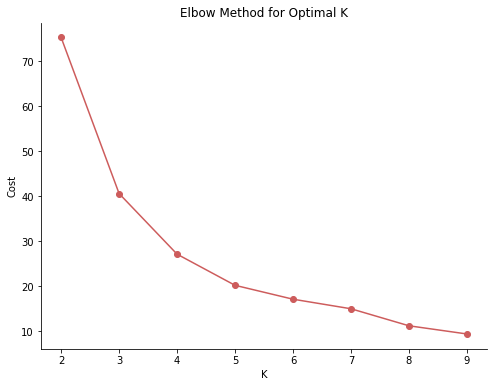

In [26]:
## plot elbow
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10], marker = "o",color='indianred')
plt.title('Elbow Method for Optimal K')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('K')
ax.set_ylabel('Cost')
plt.show()

In [27]:
# ## Silhouette method
from pyspark.ml.evaluation import ClusteringEvaluator
k_min=3
k_max=10
k_lst = np.arange(k_min, k_max+1)
silh_lst = []
for k in k_lst:
# Trains a k-means model
  kmeans = KMeans().setK(k).setSeed(int(np.random.randint(100, size=1)))
  model = kmeans.fit(scaledData)
# Make predictions
  predictions = model.transform(scaledData)
# Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  silh_lst.append(silhouette)
silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k','silhouette'])
spark.createDataFrame(silhouette).show()

+---+------------------+
|  k|        silhouette|
+---+------------------+
|  3| 0.806659969397374|
|  4|0.7003095060284757|
|  5|0.7391492869094136|
|  6|0.5241799434048069|
|  7|0.6589654082227276|
|  8|0.7116442299590126|
|  9|0.5940966739882402|
| 10|0.6626462416261224|
+---+------------------+



In [28]:
# ### Kmeans
k = 3
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(scaledData)
# Make predictions
predictions = model.transform(scaledData)
predictions.show(5,False)
# # center
# center=model.clusterCenters()
# print(center)
# print(center[1])
## predictions.toPandas().to_csv('kmeans_rfm.csv',index=False)

+----------+-------------------+---------------------------------------------------------------+----------+
|CustomerID|rfm                |features                                                       |prediction|
+----------+-------------------+---------------------------------------------------------------+----------+
|15619     |[10.0,1.0,336.4]   |[0.02680965147453083,0.0,0.016294610567853272]                 |0         |
|17389     |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |0         |
|12940     |[46.0,4.0,876.29]  |[0.12332439678284182,0.012145748987854251,0.01819712791732512] |0         |
|13623     |[30.0,7.0,672.44]  |[0.08042895442359249,0.024291497975708502,0.017478781288030567]|0         |
|14450     |[180.0,3.0,483.25] |[0.48257372654155495,0.008097165991902834,0.01681209500499777] |2         |
+----------+-------------------+---------------------------------------------------------------+----------+
only showing top 5 rows



In [29]:
## extract scaled rfm to different columns
def extract(row):
    return (row.CustomerID, ) + tuple(row.features.toArray().tolist()) +(row.prediction,)
d_sc=predictions.rdd.map(extract).toDF(["CustomerID",'r_sca','f_sca','m_sca','prediction']) 
d_sc.show(5)
from pyspark.sql.functions import *
df1 = d_sc.alias('df1')
df2 = rfm_seg.alias('df2')
df_baru=df1.join(df2, df1.CustomerID == df2.CustomerID).select('df1.*','df2.RFMScore')
df_baru.show(5)
# # df_baru.toPandas().to_csv('rfmkmean.csv',index=False)

+----------+-------------------+--------------------+--------------------+----------+
|CustomerID|              r_sca|               f_sca|               m_sca|prediction|
+----------+-------------------+--------------------+--------------------+----------+
|     15619|0.02680965147453083|                 0.0|0.016294610567853272|         0|
|     17389|                0.0|  0.1700404858299595| 0.12540746393334334|         0|
|     12940|0.12332439678284182|0.012145748987854251| 0.01819712791732512|         0|
|     13623|0.08042895442359249|0.024291497975708502|0.017478781288030567|         0|
|     14450|0.48257372654155495|0.008097165991902834| 0.01681209500499777|         2|
+----------+-------------------+--------------------+--------------------+----------+
only showing top 5 rows

+----------+--------------------+--------------------+--------------------+----------+--------+
|CustomerID|               r_sca|               f_sca|               m_sca|prediction|RFMScore|
+--------

In [49]:
from mpl_toolkits.mplot3d import axes3d

In [82]:
df_p=df_baru.rdd.sample(False,0.5,seed=1000)
df_p=spark.createDataFrame(df_p)
df_p.printSchema()

root
 |-- CustomerID: long (nullable = true)
 |-- r_sca: double (nullable = true)
 |-- f_sca: double (nullable = true)
 |-- m_sca: double (nullable = true)
 |-- prediction: long (nullable = true)
 |-- RFMScore: string (nullable = true)



In [83]:
def XScore(x):
    xs=0
    if x == '111':
        xs=0
    elif x in ('112','113','114','212','213','214','312','313','314','412','413','414'):
        xs=1
    elif x in ('121','131','141','211','221','231','241','321','331','341','421','431','441'):
        xs=2
    elif x == '331':
        xs=3
    elif x == '411':
        xs=4
    elif x == '444':
        xs=5
    else:
        xs=6
    return xs

In [84]:
from pyspark.sql.functions import udf 
from pyspark.sql.types import IntegerType
X_udf = udf(lambda x: XScore(x), IntegerType())

In [85]:
df_p=df_p.withColumn('rfm_class',X_udf('RFMScore'))
df_p.show()
df_plot=df_p.select('*').toPandas()
# # df_plot.to_csv('rfm_kmeans_pred.csv',index=False)

+----------+--------------------+--------------------+--------------------+----------+--------+---------+
|CustomerID|               r_sca|               f_sca|               m_sca|prediction|RFMScore|rfm_class|
+----------+--------------------+--------------------+--------------------+----------+--------+---------+
|     13248|  0.3324396782841823|0.004048582995951417| 0.01675018011524204|         2|     333|        6|
|     13452|  0.6943699731903485|0.004048582995951417| 0.01718827112801564|         1|     433|        6|
|     13460|  0.0777479892761394|0.004048582995951417|0.015755595113269537|         0|     234|        6|
|     13638|0.040214477211796246|                 0.0|0.015541342108309476|         0|     144|        6|
|     13723|  0.5817694369973191|                 0.0|0.015813422281220107|         2|     444|        5|
|     14117| 0.38337801608579086|                 0.0|0.015426322074067756|         2|     344|        6|
|     15057|  0.7372654155495979|0.00404858299

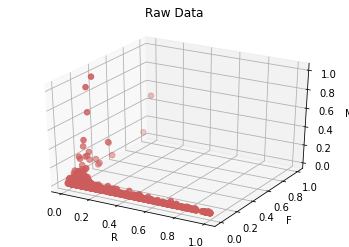

In [86]:
'''
Plot raw data; From the figure shown, there are some data that suprisingly dispersed a little too far from others, better exclude them
to get better data visualization
'''
j=plt.subplot2grid((1,1),(0,0),projection='3d')
j.scatter(xs=df_plot['r_sca'],ys=df_plot['f_sca'],zs=df_plot['m_sca'],s=30, c='indianred')
j.set_xlabel('R')
j.set_ylabel('F')
j.set_zlabel('M')
# j.set_ylim3d(0,0.2)
# j.set_zlim3d(0,0.2)
plt.title('Raw Data').set_position([.5, 1])
plt.show()

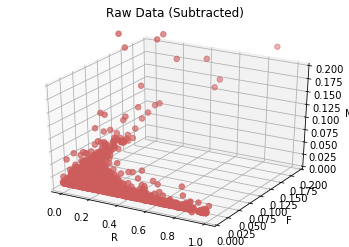

In [87]:
j=plt.subplot2grid((1,1),(0,0),projection='3d')
j.scatter(xs=df_plot['r_sca'],ys=df_plot['f_sca'],zs=df_plot['m_sca'],s=30, c='indianred')
j.set_xlabel('R')
j.set_ylabel('F')
j.set_zlabel('M')
j.set_ylim3d(0,0.2)
j.set_zlim3d(0,0.2)
plt.title('Raw Data (Subtracted)').set_position([.5, 1])
plt.show()

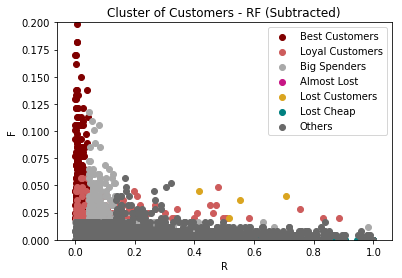

In [98]:
'''
PLOTTING RFM_Analysis

if we  want to make the chart full length, turn ylim/xlim command to comment
'''
color_plot={0:'maroon',1:'indianred',2:'darkgray',3:'mediumvioletred',4:'goldenrod',5:'teal',6:'dimgray'}
cust_label={0:'Best Customers',1:'Loyal Customers',2:'Big Spenders',3:'Almost Lost',4:'Lost Customers',5:'Lost Cheap',6:'Others'}

for c in color_plot: # iterate over color dictionary keys
        df_temp = df_plot[df_plot['rfm_class'] == c]
        plt.scatter(x = 'r_sca', y = 'f_sca', 
            data = df_temp,  
            color=color_plot[c],label=cust_label[c])
plt.xlabel('R')
plt.ylabel('F')
plt.legend()
plt.title('Cluster of Customers - RF (Subtracted)')
plt.ylim(0,0.2)
plt.show()

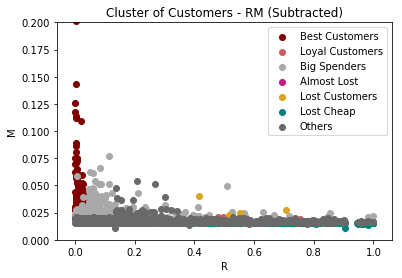

In [99]:
for c in color_plot: # iterate over color dictionary keys
        df_temp = df_plot[df_plot['rfm_class'] == c]  
        plt.scatter(x = 'r_sca', y = 'm_sca', 
            data = df_temp,  
            color=color_plot[c],label=cust_label[c])
plt.xlabel('R')
plt.ylabel('M')
plt.legend()
plt.title('Cluster of Customers - RM (Subtracted)')
plt.ylim(0,0.2)
plt.show()

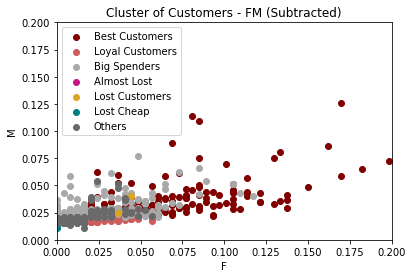

In [100]:
for c in color_plot: # iterate over color dictionary keys
        df_temp = df_plot[df_plot['rfm_class'] == c]
        plt.scatter(x = 'f_sca', y = 'm_sca', 
            data = df_temp,  
            color=color_plot[c],label=cust_label[c])
plt.xlabel('F')
plt.ylabel('M')
plt.legend()
plt.title('Cluster of Customers - FM (Subtracted)')
plt.xlim(0,0.2)
plt.ylim(0,0.2)
plt.show()

number of segment Best Customers is 244
number of segment Loyal Customers is 141
number of segment Big Spenders is 266
number of segment Almost Lost is 0
number of segment Lost Customers is 4
number of segment Lost Cheap is 196
number of segment Others is 1371


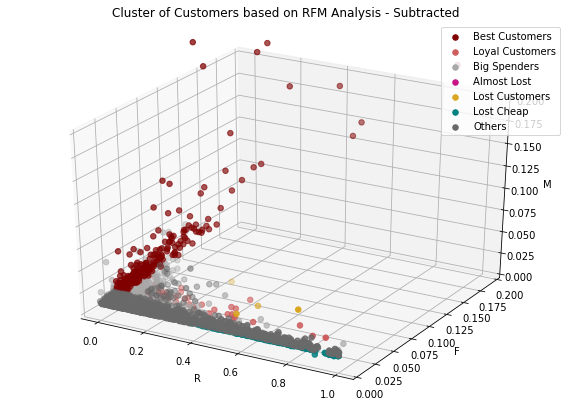

In [108]:
plt.figure(figsize=(10,7))
j=plt.subplot2grid((1,1),(0,0),projection='3d')
for c in color_plot: # iterate over color dictionary keys
    df_temp = df_plot[df_plot['rfm_class'] == c]
    print('number of segment',cust_label[c],'is',len(df_temp))
    j.scatter(xs=df_temp['r_sca'],ys=df_temp['f_sca'],zs=df_temp['m_sca'],s=30, c=color_plot[c],label=cust_label[c])
j.set_xlabel('R')
j.set_ylabel('F')
j.set_zlabel('M')
j.set_ylim3d(0,0.2)
j.set_zlim3d(0,0.2)
plt.title('Cluster of Customers based on RFM Analysis - Subtracted').set_position([.5, 1])
plt.legend(loc=1)
plt.show()

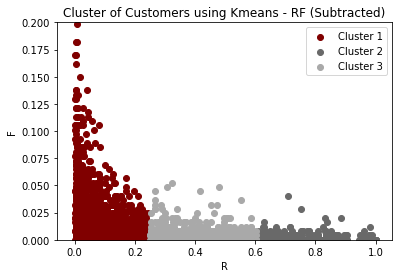

In [109]:
'''
PLOTTING K-MEANS

if we  want to make the chart full length, turn ylim/xlim command to comment
'''
color_plot={0:'maroon',1:'dimgray',2:'darkgray'}
cust_label={0:'Cluster 1',1:'Cluster 2',2:'Cluster 3'}

for c in color_plot: # iterate over color dictionary keys
        df_temp = df_plot[df_plot['prediction'] == c]
        plt.scatter(x = 'r_sca', y = 'f_sca', 
            data = df_temp,  
            color=color_plot[c],label=cust_label[c])
plt.xlabel('R')
plt.ylabel('F')
plt.legend()
plt.title('Cluster of Customers using Kmeans - RF (Subtracted)')
plt.ylim(0,0.2)
plt.show()

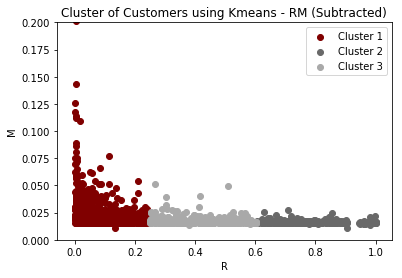

In [110]:
for c in color_plot: # iterate over color dictionary keys
        df_temp = df_plot[df_plot['prediction'] == c]
        plt.scatter(x = 'r_sca', y = 'm_sca', 
            data = df_temp,  
            color=color_plot[c],label=cust_label[c])
plt.xlabel('R')
plt.ylabel('M')
plt.legend()
plt.title('Cluster of Customers using Kmeans - RM (Subtracted)')
plt.ylim(0,0.2)
plt.show()

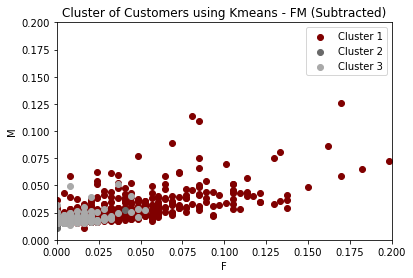

In [111]:
for c in color_plot: # iterate over color dictionary keys
        df_temp = df_plot[df_plot['prediction'] == c]
        plt.scatter(x = 'f_sca', y = 'm_sca', 
            data = df_temp,  
            color=color_plot[c],label=cust_label[c])
plt.xlabel('F')
plt.ylabel('M')
plt.legend()
plt.title('Cluster of Customers using Kmeans - FM (Subtracted)')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.show()

number of Cluster 1 is 1486
number of Cluster 2 is 316
number of Cluster 3 is 420


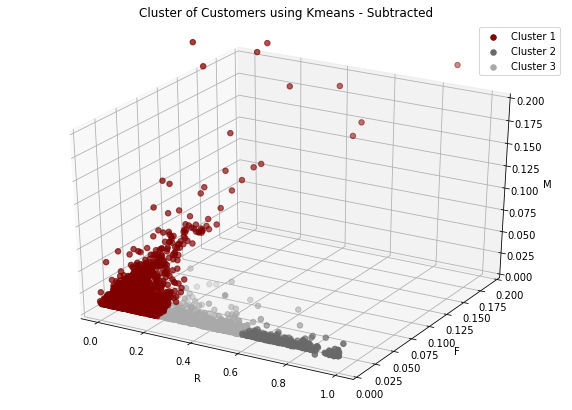

In [113]:
plt.figure(figsize=(10,7))
j=plt.subplot2grid((1,1),(0,0),projection='3d')
for c in color_plot: # iterate over color dictionary keys
    df_temp = df_plot[df_plot['prediction'] == c]
    print('number of',cust_label[c],'is',len(df_temp))
    j.scatter(xs=df_temp['r_sca'],ys=df_temp['f_sca'],zs=df_temp['m_sca'],s=30, c=color_plot[c],label=cust_label[c])
j.set_xlabel('R')
j.set_ylabel('F')
j.set_zlabel('M')
j.set_ylim3d(0,0.2)
j.set_zlim3d(0,0.2)
plt.title('Cluster of Customers using Kmeans - Subtracted').set_position([.5, 1])
plt.legend(loc=1)
plt.show()